In [108]:
import yfinance as yf
from datetime import datetime, timedelta
shop = yf.download("SHOP", start=datetime.now() - timedelta(days=500) , interval = "1d", progress=False)
len(shop)

341

2022-05-27 ~ 2023-08-11


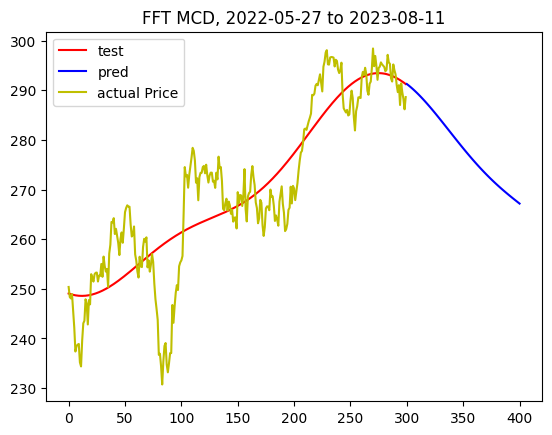

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta

def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b


def main(ticker, shop, day=0):
    start = datetime.now() - timedelta(days=441+day)
    end = start + timedelta(days=441)
    print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300
    close = shop['Close']
    close = close[::-1]
    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    for i in range(past):
        x[i] = close[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)

    plt.plot(np.arange(0, len(xm), 1), xm[::-1], color ='r', label="test")
    plt.plot(np.arange(len(xm), len(xm) + len(ym), 1), ym, color = "blue", label="pred")
    plt.plot(np.arange(0, len(xm), 1), x[::-1], color='y', label='actual Price')
    plt.title(f"FFT {ticker}, {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")
    plt.legend()
    plt.show()

main("MCD", 200, 200)

In [217]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
def main_v2(ticker, close, day):
    start =  datetime.now()- timedelta(days=1000)
    end = datetime.now() - timedelta(days=day)
    # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300

    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    # print(len(x), len(close))
    for i in range(past):
        x[i] = close[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)
    return ym
day = 150
test_len = 200
start =  datetime.now()- timedelta(days=1000+day)
end = datetime.now() - timedelta(days=day)
print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
shop = yf.download("MCD", start= start, end = end, interval = "1d", progress=False)
close = shop['Close']
linregress_array = [None] * test_len
for i in range(test_len):
    # 1/30 => 1/29 => 1/28 => ...
    close1 = close[::-1][i:i+300]
    a = main_v2("MCD", close1, 0)
    r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
    linregress_array[i] = r
print(linregress_array[::-1])


2021-01-03 ~ 2023-09-30
[-0.2027277082464067, -0.20152685182222574, -0.19903848492304027, -0.1946745011031304, -0.19248589274788383, -0.19203635948055428, -0.18769906559696647, -0.18629097233787492, -0.18181819738103946, -0.18081165170440108, -0.14639818984203412, -0.14804128992148008, -0.14804445918452744, -0.14953974355990685, -0.14857951112088544, -0.14952851192578973, -0.1509823994579201, -0.151604782589661, -0.15363768743737016, -0.15304589494066395, -0.15570913901018055, -0.158000516912943, -0.16083823040893588, -0.1543227763852376, -0.15472152786126936, -0.15459394504681617, -0.15068737137843344, -0.1513697664644097, -0.15120486075893272, -0.1508858431707328, -0.15095414057149767, -0.1506909509217082, -0.15098455086998708, -0.1512836399764719, -0.1521393886208791, -0.14629932158756467, -0.14565602114647216, -0.1469251839213149, -0.14844699415160248, -0.15046545092285998, -0.15218347066936447, -0.15279891952569546, -0.15370534116490916, -0.15302610151870594, -0.15172880675999617,

                 close    linreg    EMA_20    EMA_60
Date                                                
2022-12-13  274.279999 -0.202728       NaN       NaN
2022-12-14  274.529999 -0.201527       NaN       NaN
2022-12-15  271.730011 -0.199038       NaN       NaN
2022-12-16  266.119995 -0.194675       NaN       NaN
2022-12-19  265.829987 -0.192486       NaN       NaN
...                ...       ...       ...       ...
2023-09-25  269.779999 -0.228537 -0.216956 -0.212774
2023-09-26  267.720001 -0.230718 -0.218266 -0.213362
2023-09-27  263.640015 -0.234161 -0.219780 -0.214044
2023-09-28  265.589996 -0.235440 -0.221272 -0.214746
2023-09-29  263.440002 -0.238228 -0.222886 -0.215515

[200 rows x 4 columns]


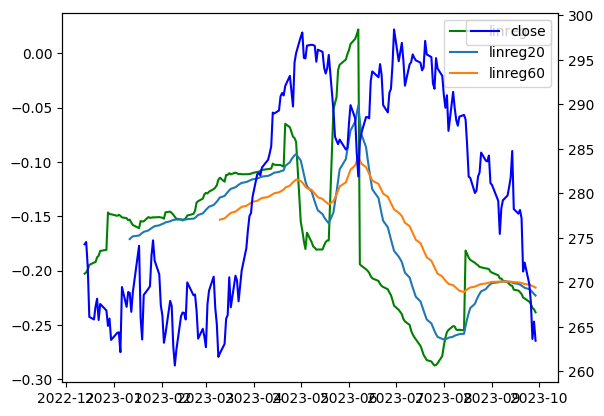

In [218]:
show = [i if i != 0 else 1 for i in linregress_array]
import pandas_ta as ta
ma1 = 20
ma2 = 60
# print(linregress_array)
fig, ax1 = plt.subplots()
df = pd.DataFrame({'close':close[-test_len:], 'linreg':show[::-1]}, index=close.index[-test_len:])
df.ta.ema(close='linreg', length=ma1, append=True)
df.ta.ema(close='linreg', length=ma2, append=True)
print(df)
ax2 = ax1.twinx()
ax1.plot(close.index[-test_len:], show[::-1], 'g-', label='linreg')
ax1.plot(close.index[-test_len:], df[f'EMA_{ma1}'], label=f'linreg{ma1}')
ax1.plot(close.index[-test_len:], df[f'EMA_{ma2}'], label=f'linreg{ma2}')
ax2.plot(close.index[-test_len:], close[-test_len:], 'b-', label='close')

ax1.legend()
ax2.legend()
plt.show()

In [ ]:
im